# 210421 Fix Component 9

In [1]:
const COMPONENT = 9;

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11010659142824046875\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14550468590915659974\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11010659142824046875\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: Precompiling OverlapAnalysis [f4957492-94e1-4ddd-992d-2c04f2767020]
└ @ Base loading.jl:1278
┌ Info: Precompiling OverlapPlots [a6cb5d23-075a-4f87-9833-75c535e9dcec]
└ @ Base loading.jl:1278


5×14 DataFrame
 Row │ id     ncbi_id  name                  rank     parent_id  in_v12  manual_threshold  report  ngenomes  comp_idx  diameter  outgoing  incoming  name_abbr      
     │ Int64  Int64?   String                String?  Int64?     Bool    Float64           Bool    Int64     Int64     Float32   Int64     Int64     String         
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   626      562  Escherichia coli      species        149    true              NaN     true      4204         1  0.718016         4         2  E. coli
   2 │   645      622  Shigella dysenteriae  species        161    true              NaN     true         6         3  0.56022          4         2  S. dysenteriae
   3 │   644      621  Shigella boydii       species        161    true              NaN     true        13         2  0.296933         1         2  S. boydii
   4 │   648      624  Shigella sonnei       species        161    true              NaN     true       563         5  0.373258         1         2  S. sonnei
   5 │   646      623  Shigella flexneri     species        161    true              NaN     true       104         4  0.261437         0         2  S. flexneri

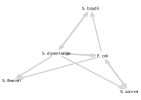

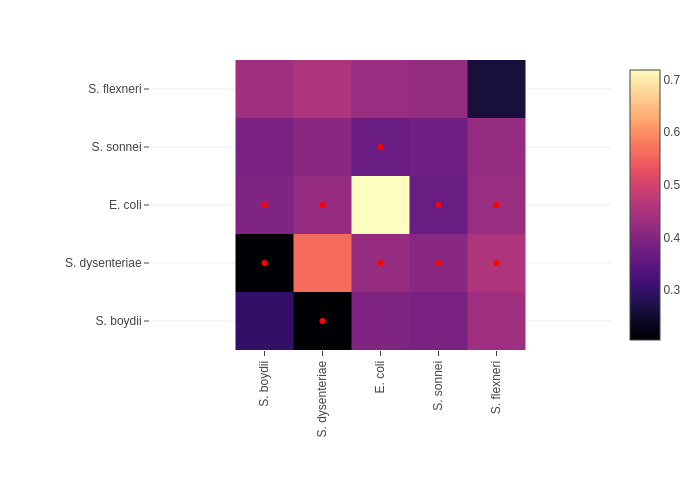

In [2]:
include("fix-component-base.jl");

In [3]:
trees = Dict{String, Any}();

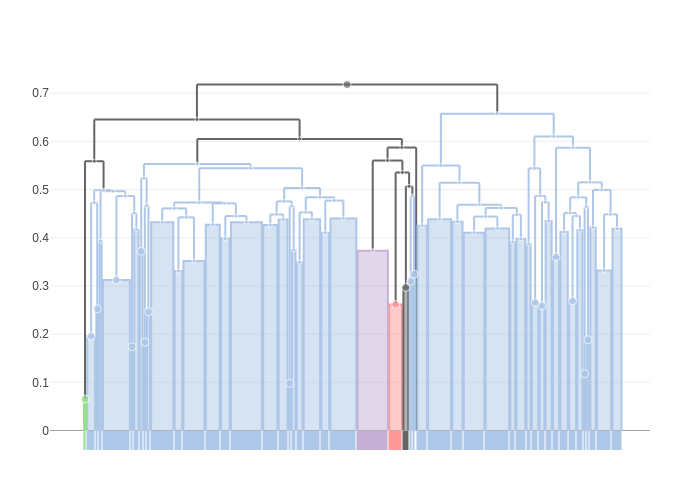

In [4]:
trees["all"] = cluster_annotate(cdata, 1:cdata.ntaxa)
plot(dendrogram(cdata, trees["all"]))

## Shigella species in isolation

E. coli is going to be the real mess, but start with single Shigella species that have outgoing overlaps to see if there are any obvious fixes there to start.

### S. dysenteriae

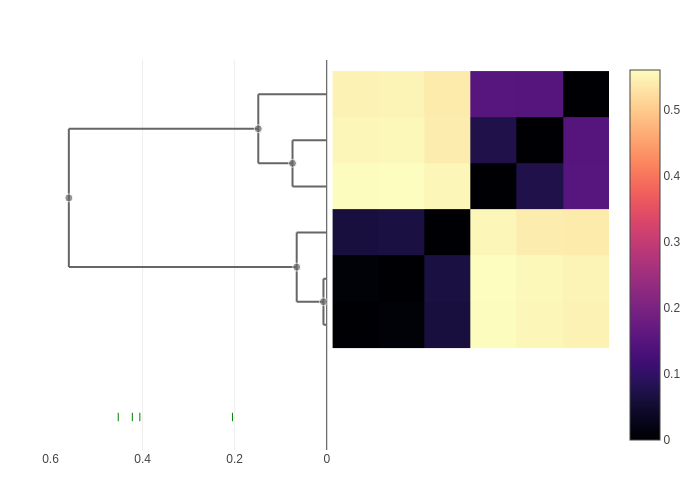

In [5]:
let taxon = "S. dysenteriae"
    trees[taxon] = cluster_annotate(cdata, taxon)
    plot(clustermap(cdata, trees[taxon]))
end

In [6]:
split_taxon!(edits, trees["S. dysenteriae"], [8, 10])

Subgroup 1 size: 3
Subgroup 2 size: 3
Genomes to delete: 0


### S. sonnei

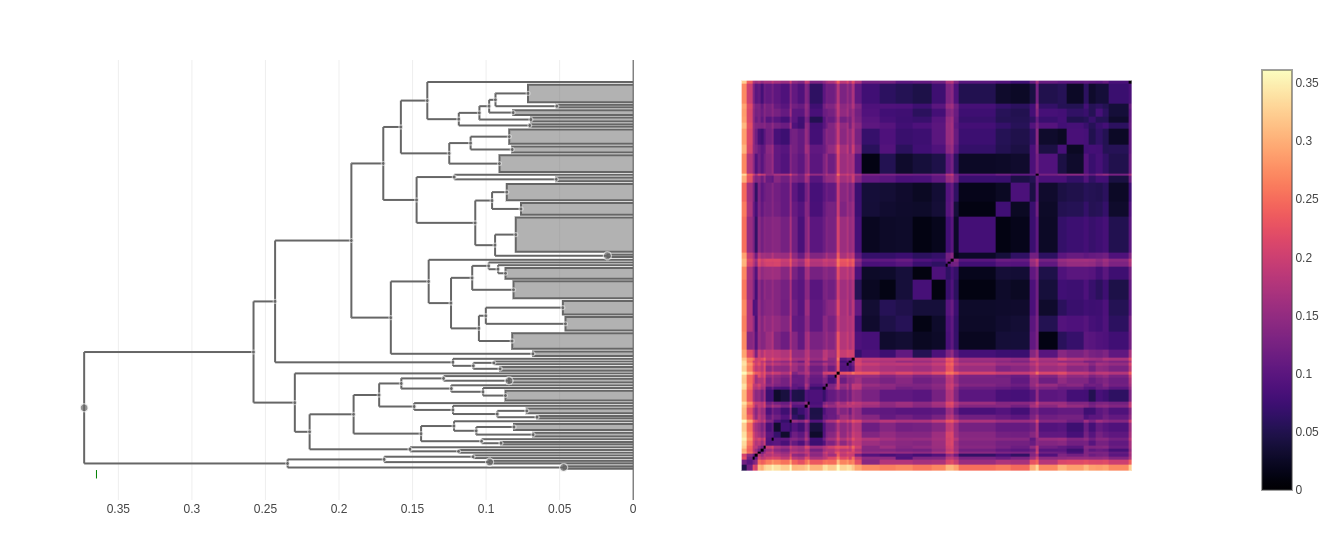

In [7]:
let taxon = "S. sonnei"
    trees[taxon] = cluster_annotate(cdata, taxon)
    plot(clustermap(cdata, trees[taxon]))
end

In [8]:
keep_subtrees!(edits, trees["S. sonnei"], 1124)

#5 S. sonnei:
	6/563 removed
	Diameter 0.3733 => 0.2581


### S. boydii

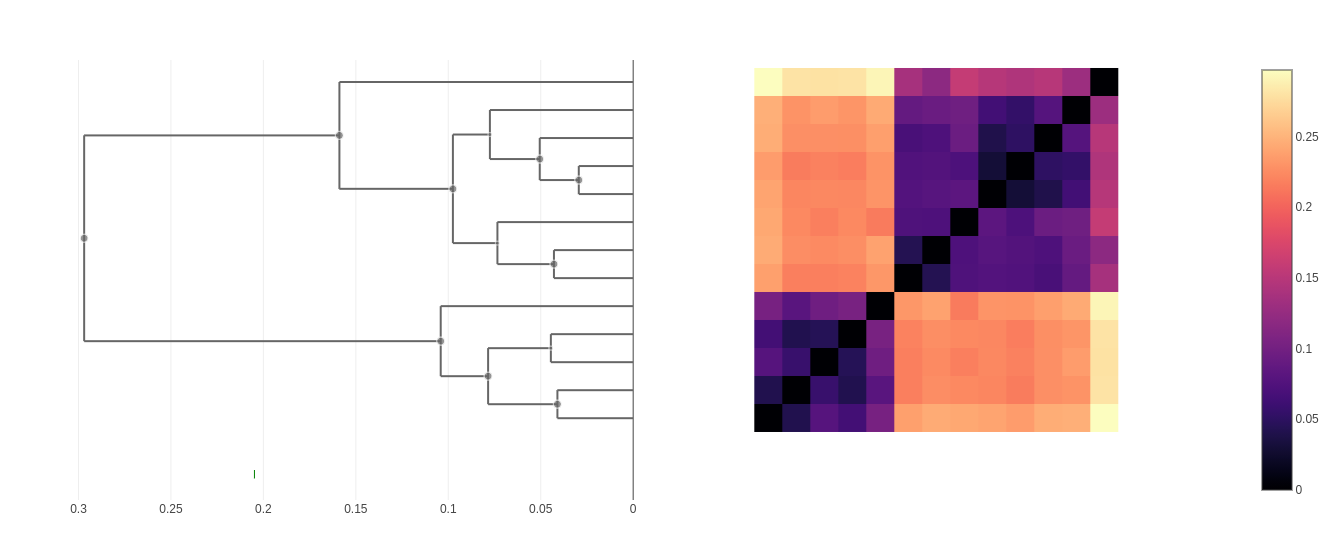

In [9]:
let taxon = "S. boydii"
    trees[taxon] = cluster_annotate(cdata, taxon)
    plot(clustermap(cdata, trees[taxon]))
end

In [10]:
split_taxon!(edits, trees["S. boydii"], [24, 23])

Subgroup 1 size: 8
Subgroup 2 size: 5
Genomes to delete: 0


## E. coli split

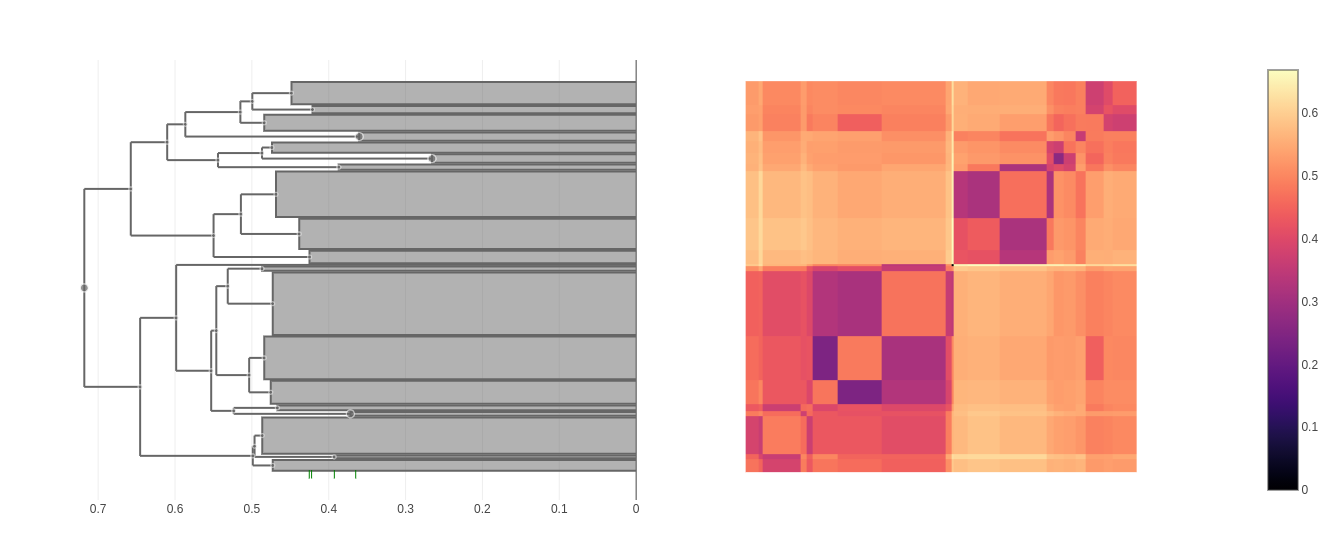

In [11]:
let taxon = "E. coli"
    trees[taxon] = cluster_annotate(cdata, taxon)
    plot(clustermap(cdata, trees[taxon], max_leaves=20))
end

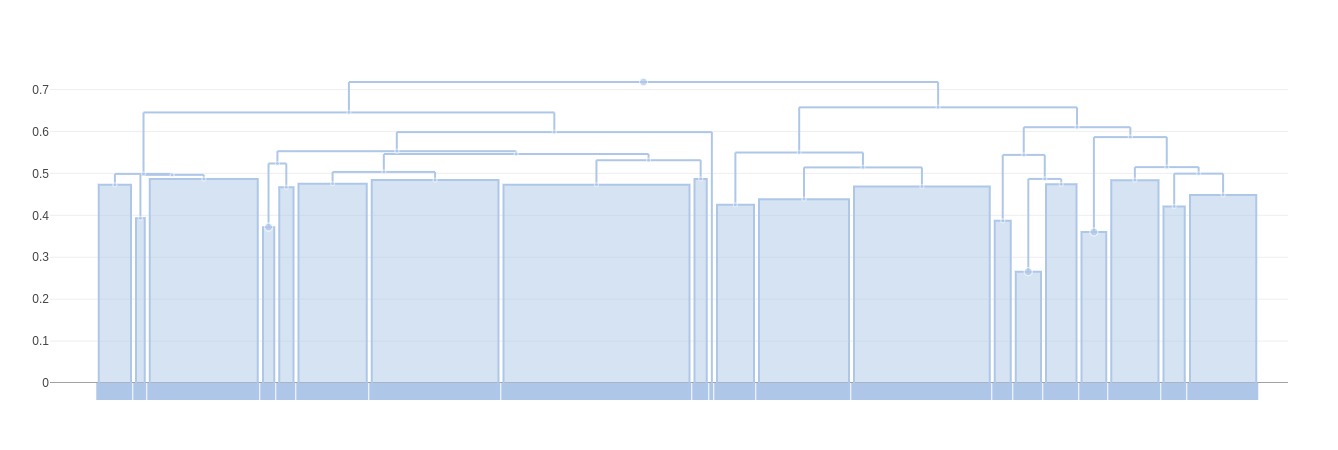

In [12]:
dendrogram(cdata, ["E. coli"], max_leaves=20)

In [13]:
split_taxon!(edits, trees["E. coli"], [8406, 8401, 8391])
# split_taxon!(edits, trees["E. coli"], [8400, 8404, 8403, 8391])

Subgroup 1 size: 1487
Subgroup 2 size: 2208
Subgroup 3 size: 508
Genomes to delete: 1


## View E. coli split results

In [14]:
cdata2 = apply_edits(edits);

### Individual subgroups

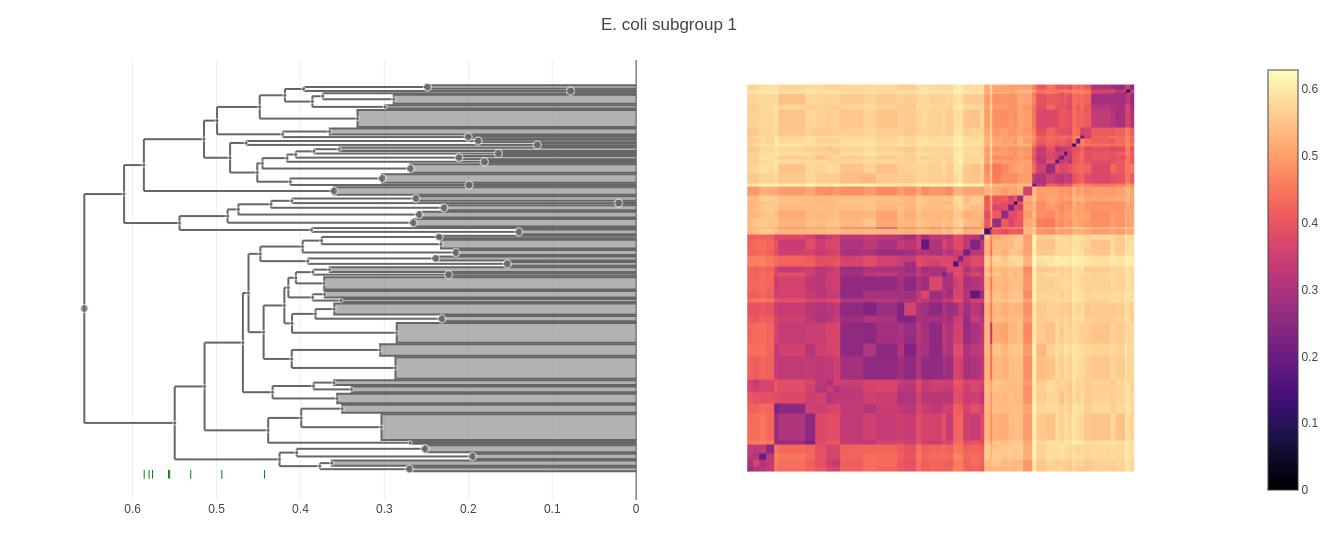

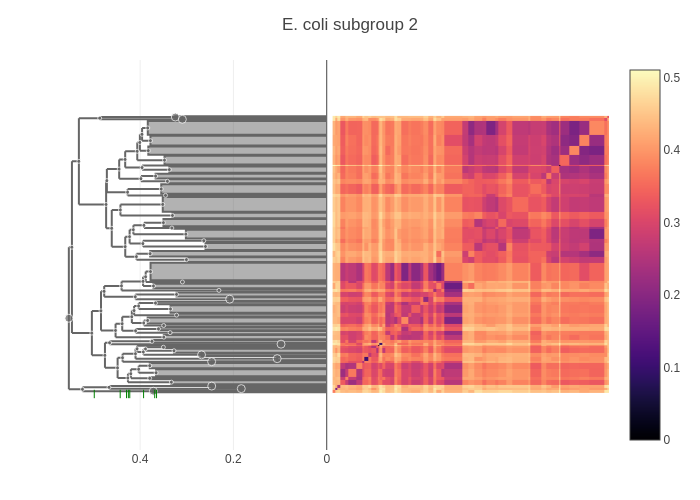

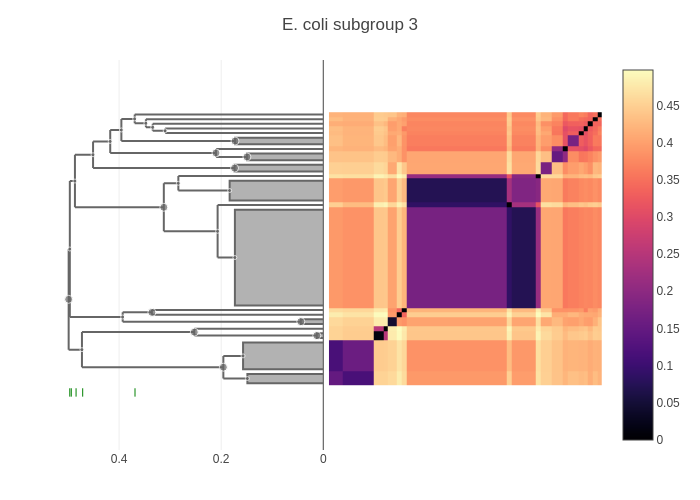

In [15]:
for i in 1:3
    name = "E. coli subgroup $i"
    plt = clustermap(cdata2, name)
    relayout!(plt, title_text=name)
    display(plot(plt))
end

### Full component tree

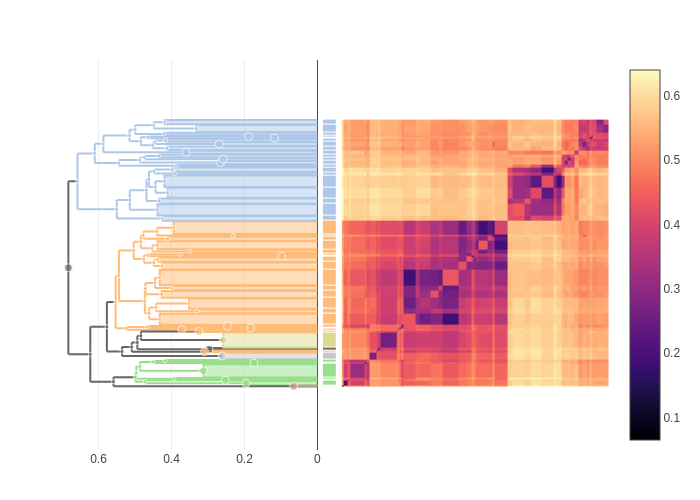

In [16]:
let key = "all-after-split"
    trees[key] = cluster_annotate(cdata2, 1:cdata2.ntaxa)
    plt = multi_clustermap(cdata2, trees[key], max_leaves=50)
    relayout!(plt, width=1200, height=800)
    plot(plt)
end

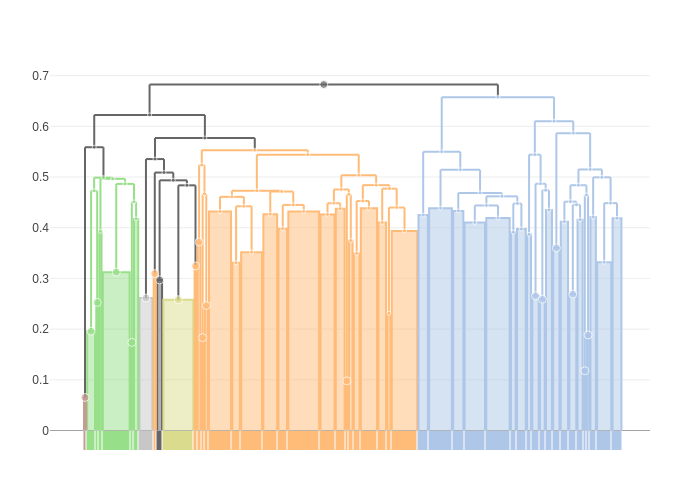

In [17]:
plot(dendrogram(cdata2, trees["all-after-split"], max_leaves=50))

Zoom in on mixed subtree in above dendrogram:

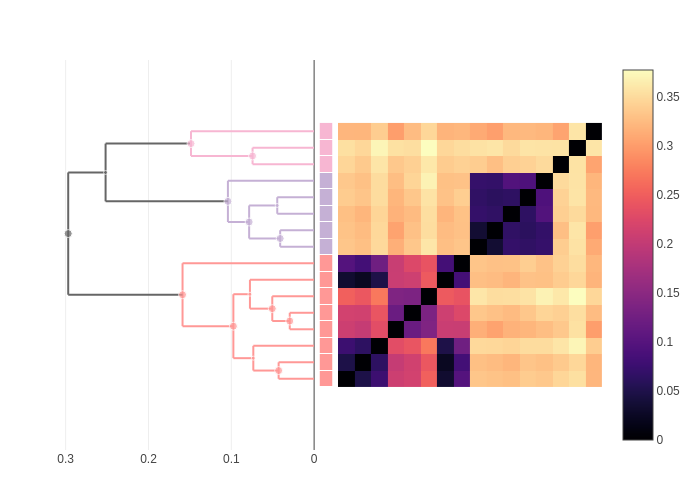

In [18]:
using ClusterAnalysis

let tree = trees["all-after-split"], root_id = 9475
    subtree, id_map = ClusterAnalysis.get_subtree(tree, root_id)
    plot(multi_clustermap(cdata2, subtree))
end

Looks fine.

## Touch up E. coli subgroups

In [19]:
edits2 = DatabaseEdits(cdata2);

### Subgroup 1

Based on plot above

In [20]:
set_threshold!(edits2, "E. coli subgroup 1", .4)

0.4

### Subgroup 3

Based on plot above

In [21]:
set_threshold!(edits2, "E. coli subgroup 3", .35)

0.35

### Subgroup 2

Remove subtree of E. coli subgroup 2 that clusters away from the rest in full tree:

In [22]:
remove_subtrees!(edits2, trees["all-after-split"], 9515)

#2 E. coli subgroup 2:
	4/2208 removed
	Diameter 0.5529 => 0.5529


Check plot again:

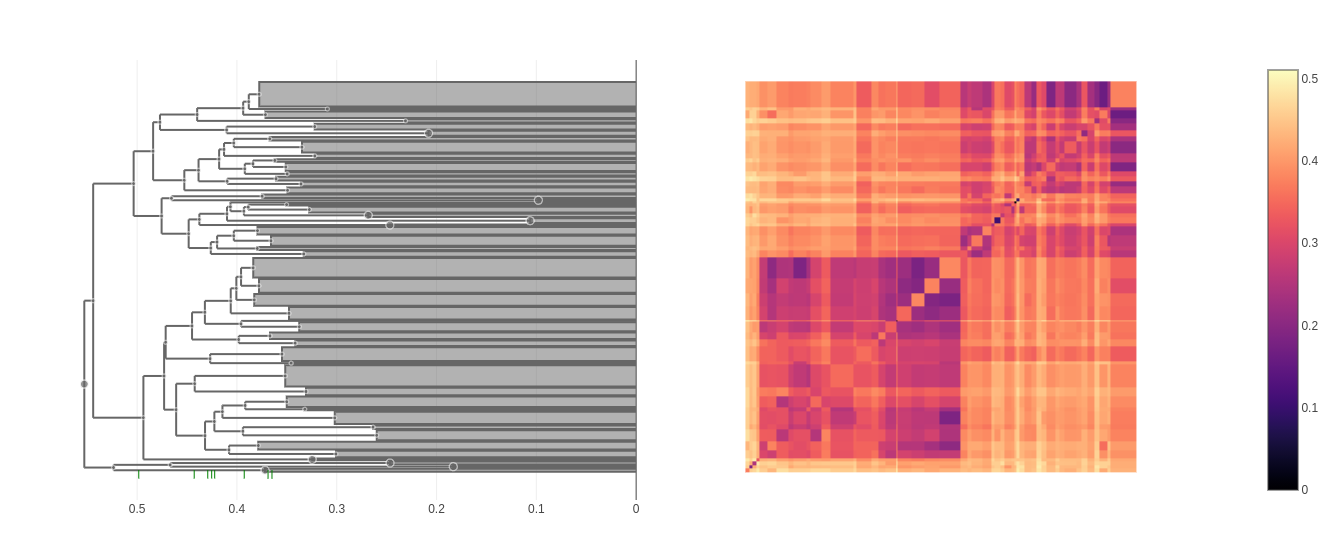

In [23]:
let edited = apply_edits(edits2)
    plot(clustermap(edited, "E. coli subgroup 2"))
end

In [24]:
set_threshold!(edits2, "E. coli subgroup 2", .35)

0.35

## Merge edits

Not currently able to merge multiple sets of edits together in general, limited support in these notebooks for also saving a 2nd set of edits containing only manual threshold assignments for subgroups created in previous set. That doesn't work in this case because the 2nd set of edits also includes some more removed genomes.

In [25]:
edits_final = DatabaseEdits(cdata)

# Removed genomes from both sets of edits
union!(edits_final.removed_genomes, edits.removed_genomes)
union!(edits_final.removed_genomes, edits2.removed_genomes)

# Copy splits but make sure any removed genomes don't make it into subgroups
for (ti, subgroup_gidxs) in edits.split_taxa
    edits_final.split_taxa[ti] = [
        setdiff(gidxs, edits_final.removed_genomes)
        for gidxs in subgroup_gidxs
    ]
end

OverlapAnalysis.validate_edits(edits_final)

In [26]:
# Version of edits2 with only manual thresholds applied to E coli subgroups
edits2_final = DatabaseEdits(apply_edits(edits_final))
merge!(edits2_final.manual_thresholds, edits2.manual_thresholds);

## Finish

In [27]:
complete_edits(edits_final, edits2_final)

4×9 DataFrame
 Row │ index  name            ngenomes  initial_diameter  taxon_removed  removed_genomes  split            manual_threshold  final_diameter         
     │ Int64  String          Int64     Float32           Bool           Int64            String           Missing           String                 
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     1  E. coli             4204          0.718016          false                5  1487, 2204, 508          missing   0.6576, 0.5529, 0.4988
   2 │     2  S. boydii             13          0.296933          false                0  8, 5                     missing   0.1589, 0.1041
   3 │     3  S. dysenteriae         6          0.56022           false                0  3, 3                     missing   0.0652, 0.1487
   4 │     5  S. sonnei            563          0.373258          false                6                           missing   0.2581